In [1]:
import os

network_path = os.path.join("networks", "FS_SPN_feed_forward")

input_name = "FS_SPN_feed_forward"
sim_file_gj = os.path.join(network_path, "simulation", f"output-GJ-{input_name}.hdf5")
sim_file_nogj = os.path.join(network_path, "simulation", f"output-noGJ-{input_name}.hdf5")

input_config = f"{input_name}-input.json"
duration=3
osc_freq = 20

modified_network = os.path.join(network_path, "network-synapses-ablated.hdf5")

In [2]:
from snudda.init import SnuddaInit

from snudda.init.init import SnuddaInit
cnc = SnuddaInit(struct_def={}, network_path=network_path, random_seed=1337,
                 snudda_data="../../../../BasalGangliaData/data/")
# To get only FS density we would use 0.013*80500, but then we also have dSPN and iSPN here in network
# so we need to compensate to get the correct FS neuron density (which is the important part)

num_FS = 40
num_dSPN_orig = 80
num_iSPN_orig = 80
num_dSPN_final = 10
num_iSPN_final = 10

cnc.define_striatum(num_dSPN=num_dSPN_orig, num_iSPN=num_iSPN_orig, num_FS=num_FS, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neuron_density=0.013*80500*(1 + (num_dSPN_orig + num_iSPN_orig)/num_FS))
cnc.add_population_unit_random("Striatum", "FS", 1.0, 1)
cnc.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Adding neurons: dSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
Writing networks/FS_SPN_feed_forward/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json


In [4]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, verbose=False)
sd.detect()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 114/343 (197 neurons)
Processing hyper voxel : 121/343 (173 neurons)
Processing hyper voxel : 163/343 (167 neurons)
Processing hyper voxel : 170/343 (140 neurons)
Processing hyper voxel : 113/343 (122 neurons)
Processing hyper voxel : 115/343 (122 neurons)
Processing hyper voxel : 162/343 (96 neurons)
Processing hyper voxel : 164/343 (94 neurons)
Processing hyper voxel : 107/343 (93 neurons)
Processing hyper voxel : 120/343 (93 neurons)
Processing hyper voxel : 122/343 (92 neurons)
Processing hyper voxel : 65/343 (81 neurons)
Processing hyper voxel : 169/343 (78 neurons)
Processing hyper voxel : 171/343 (67 neurons)
Processing hyper voxel : 72/343 (61 neurons)
Processing hyper voxel : 156/343 (51 neurons)
Processing hyper voxel : 106/343 (44 neurons)
Processing hyper voxel : 108/343 (38 neurons)
P

In [5]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

Read 116040 out of total 116040 synapses
Read 548 out of total 548 gapJunctions


### Ablating network
It is important that the SPN networks receive a full set of FS inputs, so we want to only keep the SPN that are in the core.

In [6]:
from snudda.utils import SnuddaLoad
from snudda.utils.ablate_network import SnuddaAblateNetwork
mod_network = SnuddaAblateNetwork(network_file=os.path.join(network_path, "network-synapses.hdf5"))
orig_sl = SnuddaLoad(network_path)
orig_fs_id = orig_sl.get_neuron_id_of_type("FS")
orig_dspn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="dSPN", n_neurons=num_dSPN_final)]
orig_ispn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="iSPN", n_neurons=num_iSPN_final)]

keep_id = set(list(orig_fs_id) + list(orig_dspn_id) + list(orig_ispn_id)) 
mod_network.only_keep_neuron_id(keep_id)
mod_network.write_network(modified_network)

Loading 200 neurons with 8899 synapses and 145 gap junctions
Loading 200 neurons with 8899 synapses and 145 gap junctions
Writing to networks/FS_SPN_feed_forward/network-synapses-ablated.hdf5
Copying morphologies
Keeping 60 neurons.
0/8899 synapses processed
8899/8899 synapses processed
Filtering done.
0/145 synapses processed
145/145 synapses processed
Filtering done.
Copying synapses and gap junctions
1176 / 1176 synapse rows parsed
Synapse matrix written.
Keeping 1176 synapses (out of 8899)
0 / 145 gap junction rows parsed
145 / 145 gap junction rows parsed
Gap junction matrix written.
Keeping 145  gap junctions (out of 145)


Loading 60 neurons with 1176 synapses and 145 gap junctions
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json


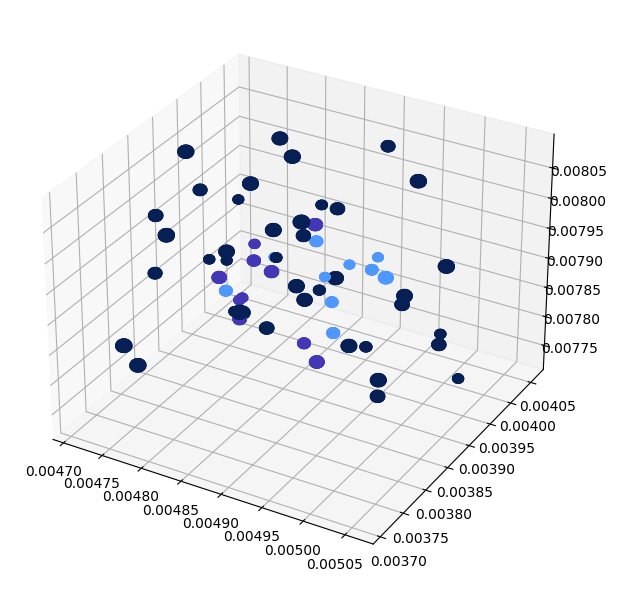

(<module 'matplotlib.pyplot' from '/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 <Axes3DSubplot:>)

In [7]:
from snudda.plotting.plot_network import PlotNetwork
pn = PlotNetwork(modified_network)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)

In [8]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path,
                 hdf5_network_file=modified_network,
                 input_config_file=f"{input_name}-input.json",
                 verbose=False)
si.generate()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Loading 60 neurons with 1176 synapses and 145 gap junctions
!!! Warning, combining definition of cortical_background input for neuron FS_3 0 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 1 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron dSPN_2 2 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron dSPN_2 2 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 3 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 4 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron dSPN_3 5 (meta modified by input_config)
!!! Warning, combining definition 

Loading 60 neurons with 1176 synapses and 145 gap junctions


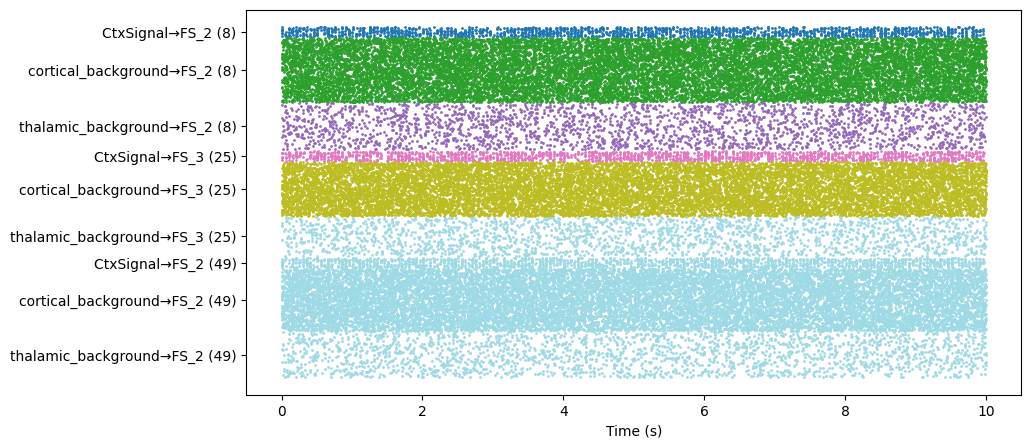

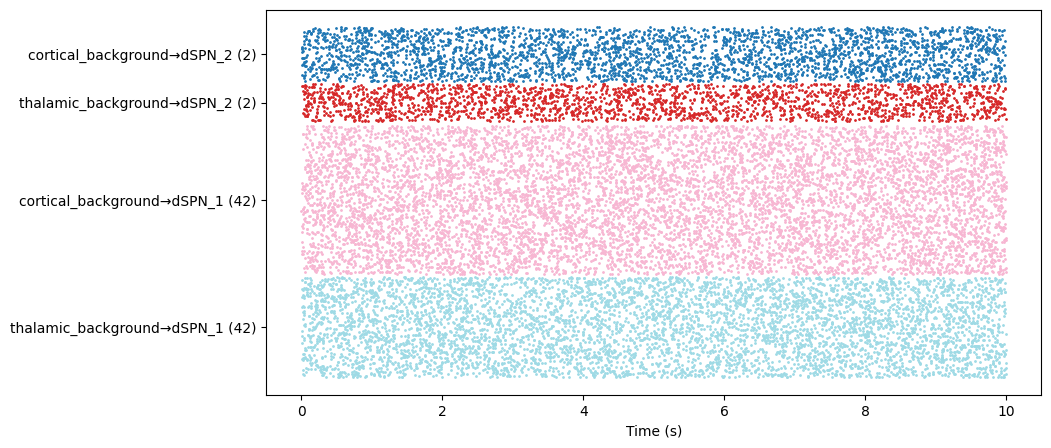

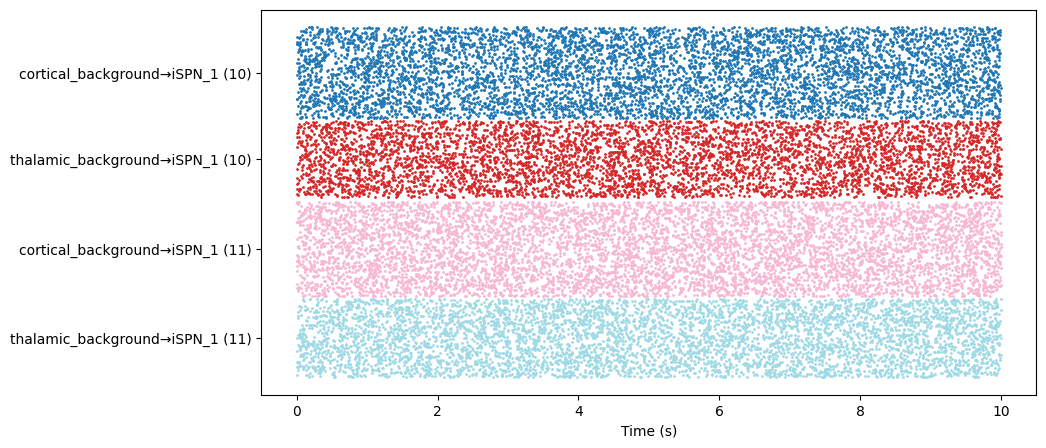

In [9]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file, network_path=modified_network)
spi.plot_input(neuron_type="FS", num_neurons=3)
spi.plot_input(neuron_type="dSPN", num_neurons=2)
spi.plot_input(neuron_type="iSPN", num_neurons=2)

In [10]:
os.system(f"mpiexec -n 3 snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_gj}")

numprocs=3
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Running on master node:  nrnivmodl /home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjo

0

In [11]:
os.system(f"mpiexec -n 3 snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_nogj} --disableGJ")

numprocs=3
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Worker waiting for master node to compile NEURON modules.
Using input file networks/FS_SPN_feed_forward/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/FS_SPN_feed_forward/network-config.json
Running on master node:  nrnivmodl /home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms
/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "/home/hjorth/HBP/BasalGangliaData/data/neurons/mechanisms//home/hjo

0

In [12]:
from snudda.utils import SnuddaLoad
from snudda.utils import SnuddaLoadNetworkSimulation

sl = SnuddaLoad(modified_network)
sls_gj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_gj)
sls_nogj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_nogj)

n_centre=10

nid_fs = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="FS")]
nid_dspn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="dSPN")]
nid_ispn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="iSPN")]

Loading 60 neurons with 1176 synapses and 145 gap junctions
Loading networks/FS_SPN_feed_forward/simulation/output-GJ-FS_SPN_feed_forward.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
3: (FS_0, pb1ef6b01, m4cd420e2)
15: (FS_1, pf9439e45, m48f576bb)
19: (FS_1, pf9439e45, m9d1605c7)
20: (iSPN_0, p581376d6, m3a845add)
24: (FS_1, p31916918, meffc0dfa)
32: (FS_0, p4feff98b, m86da4874)
42: (dSPN_1, p81757e87, mad2e6da1)
46: (FS_0, pb1ef6b01, mb1b67bcc)
Loading networks/FS_SPN_feed_forward/simulation/output-noGJ-FS_SPN_feed_forward.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
3: (FS_0, pb1ef6b01, m4cd420e2)
20: (iSPN_0, p581376d6, m3a845add)
32: (FS_0, p4feff98b, m86da4874)
40: (FS_0, p59a48310, me486b19e)
42: (dSPN_1, p81757e87, mad2e6da1)
46: (FS_0, pb1ef6b01, mb1b67bcc)


Loading network info from networks/FS_SPN_feed_forward/network-synapses-ablated.hdf5
Loading 60 neurons with 1176 synapses and 145 gap junctions
Loading input info from networks/FS_SPN_feed_forward/input-spikes.hdf5
Loading networks/FS_SPN_feed_forward/simulation/output-GJ-FS_SPN_feed_forward.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
3: (FS_0, pb1ef6b01, m4cd420e2)
15: (FS_1, pf9439e45, m48f576bb)
19: (FS_1, pf9439e45, m9d1605c7)
20: (iSPN_0, p581376d6, m3a845add)
24: (FS_1, p31916918, meffc0dfa)
32: (FS_0, p4feff98b, m86da4874)
42: (dSPN_1, p81757e87, mad2e6da1)
46: (FS_0, pb1ef6b01, mb1b67bcc)
Plotting traces: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Plotted 60 traces (total 60)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/FS-ne

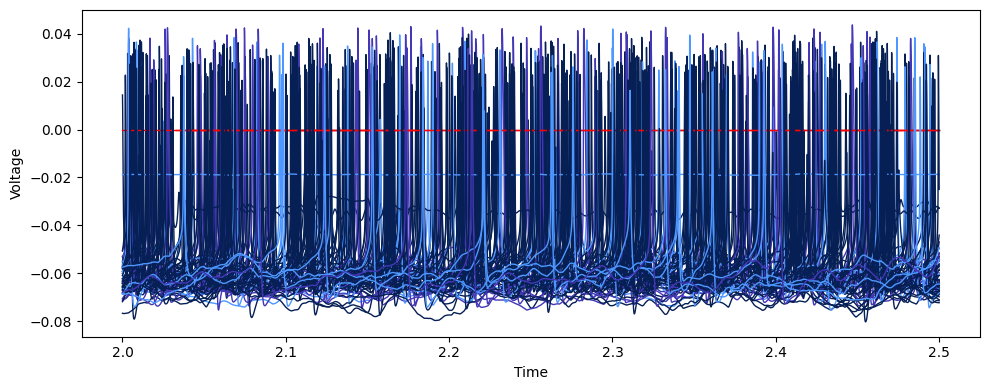

In [13]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file_gj, network_file=modified_network)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

Loading network info from networks/FS_SPN_feed_forward/network-synapses-ablated.hdf5
Loading 60 neurons with 1176 synapses and 145 gap junctions
Loading input info from networks/FS_SPN_feed_forward/input-spikes.hdf5
Loading networks/FS_SPN_feed_forward/simulation/output-noGJ-FS_SPN_feed_forward.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
3: (FS_0, pb1ef6b01, m4cd420e2)
20: (iSPN_0, p581376d6, m3a845add)
32: (FS_0, p4feff98b, m86da4874)
40: (FS_0, p59a48310, me486b19e)
42: (dSPN_1, p81757e87, mad2e6da1)
46: (FS_0, pb1ef6b01, mb1b67bcc)
Plotting traces: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Plotted 60 traces (total 60)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/FS-network/networks/FS_SPN_feed_forward/figures/Network-voltage-trace

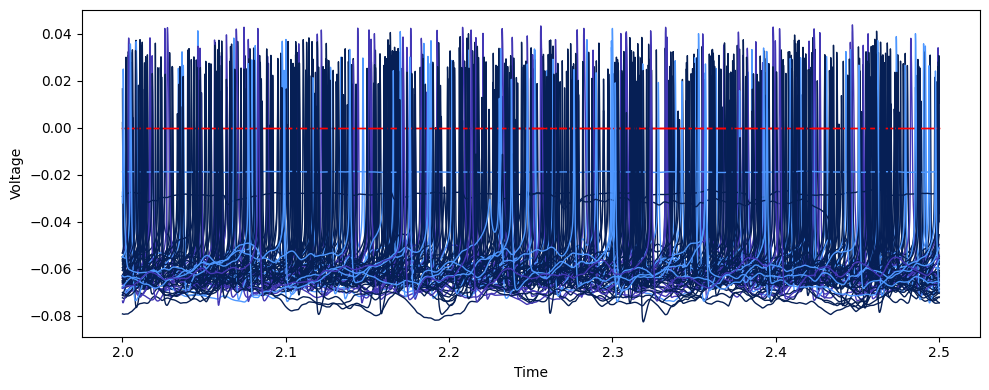

In [14]:
from snudda.plotting.plot_traces import PlotTraces
pt2 = PlotTraces(output_file=sim_file_nogj, network_file=modified_network)
ax2 = pt2.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

Writing figure to networks/FS_SPN_feed_forward/figures/spike-period-histogram.pdf
Writing figure to networks/FS_SPN_feed_forward/figures/spike-period-histogram.pdf
Writing figure to networks/FS_SPN_feed_forward/figures/spike-period-histogram.pdf


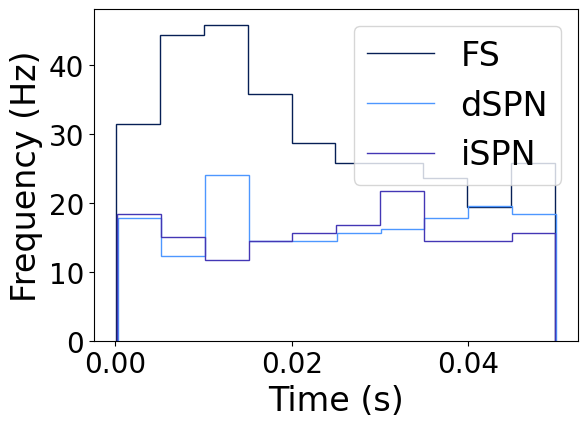

In [23]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr = SnuddaPlotSpikeRaster2(network_path=network_path,
                             network_file=modified_network,
                             simulation_file=sim_file_gj,
                             snudda_load=sl, snudda_simulation_load=sls_gj)
time_range = (1,3)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS", color=spr.get_colours("FS"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                        exclude_depolarisation_blocked_neurons=True)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN", ax=ax, color=spr.get_colours("iSPN"),
                                        exclude_depolarisation_blocked_neurons=True)

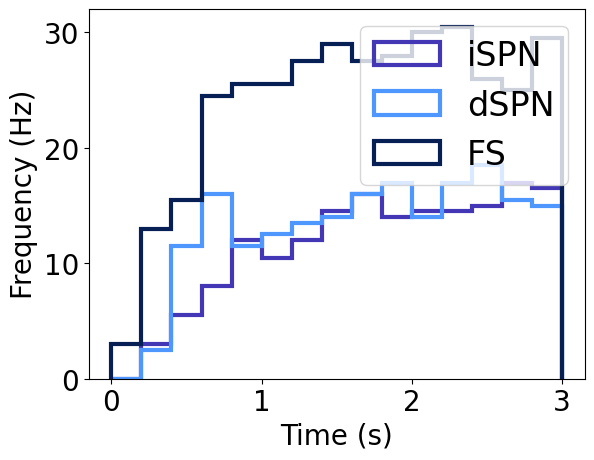

In [16]:
spr.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3, n_core=10)

Writing figure to networks/FS_SPN_feed_forward/figures/spike-period-histogram.pdf
Writing figure to networks/FS_SPN_feed_forward/figures/spike-period-histogram.pdf
Writing figure to networks/FS_SPN_feed_forward/figures/spike-period-histogram.pdf


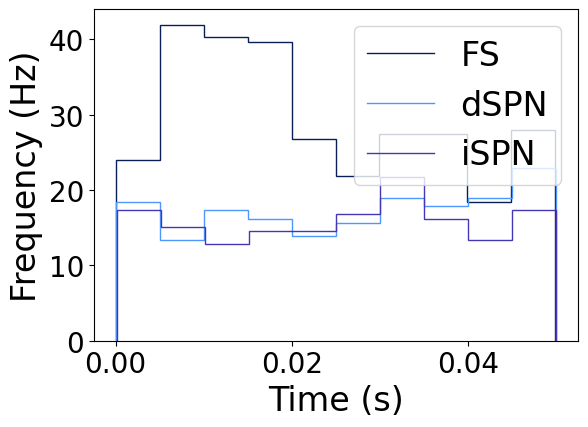

In [24]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, 
                              network_file=modified_network,
                              simulation_file=sim_file_nogj,
                              snudda_load=sl, snudda_simulation_load=sls_nogj)

time_range = (1,3)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS", color=spr.get_colours("FS"), show_figure=False,
                                          exclude_depolarisation_blocked_neurons=True)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN", ax=ax, color=spr.get_colours("iSPN"),
                                         exclude_depolarisation_blocked_neurons=True)

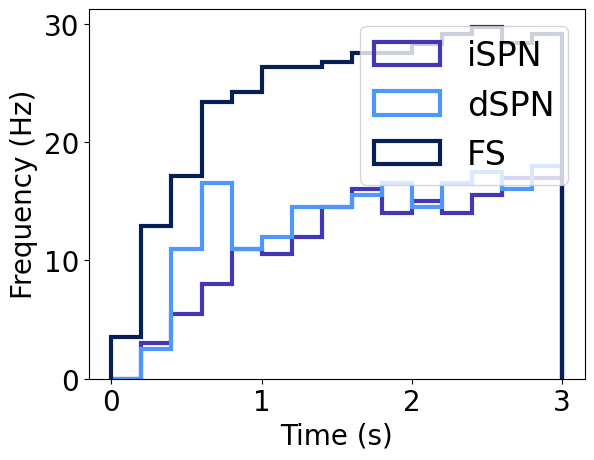

In [18]:
spr2.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3)